# # Full Cross-Validation and Final Training Evaluation Notebook
# 
# This notebook performs graph neural network (GNN)-based classification or regression using a custom Message Passing Neural Network (MPNN) architecture. It supports training with 5-fold cross-validation and then retrains a final model on combined data using early stopping. Performance is evaluated on a held-out test set.
# 
# ## 🧭 Workflow Overview
# 
# ### Step 1. Imports and Setup
# - Load libraries including PyTorch, PyTorch Geometric, and scikit-learn.
# - Configure plotting and file management tools.
# 
# ### Step 2. Task and Reproducibility Setup
# - Set task: `task = "classification"` or `"regression"`.
# - Configure reproducibility with a fixed random seed for reproducibility
# - Define class names if applicable and set up result directories.
# 
# ### Step 3. Model Definition
# - Define an MPNN layer and model using PyTorch Geometric.
# - The model takes node and edge features and outputs class scores or scalar predictions.
# 
# ### Step 4. Evaluation Helper Function
# - Implements an `evaluate(model, loader)` function to return model outputs and ground truths.
# 
# ### Step 5. Input Dimensions and Device Setup
# - Determine input feature dimensions from dataset.
# - Detect and assign appropriate device (CPU or GPU).
# 
# ### Step 6. Cross-Validation Training and Evaluation
# - Train the model across 5 folds using pre-split datasets from ../4_train_test_split/5fold_cv/{task}/
.
# - Log metrics per fold:
#   - **Classification**: accuracy, precision, recall, F1, AUC-ROC
#   - **Regression**: MAE, MSE, RMSE, R²
# - Save all results to CSV.
# 
# ### Step 7. Final Model Training and Test Evaluation
# - Merge all training and validation folds.
# - Reserve a small stratified/random validation split.
# - Train model with:
#   - **Early stopping** (based on validation loss)
#   - **Learning rate scheduler**
#   - **Model checkpointing** (saves best model)
# - Evaluate on the held-out test set and save predictions + plots.
# 
# ### Step 8. Cross-Validation Results Visualization
# - Plot fold-wise bar charts for key metrics.
# - Display mean and standard deviation summary.
# 
# ### Step 9. Interpreting Final Model AUC-ROC and Confusion Matrix
# - Provide interpretation of model behavior:
#   - AUC-ROC curve → how well the model separates classes
#   - Confusion matrix → where the model gets confused
# - Identify any class-specific issues 
#
# ---
#
# ## 🛠 Parameters That Can Be optimized/tuned
#
# - **Hidden dimension** of MPNN: `hidden_dim`
# - **Learning rate**: `lr` in `Adam` optimizer
# - **Batch size**: affects convergence speed and generalization
# - **Early stopping patience**: number of epochs without improvement
# - **Scheduler factor/patience**: reduce LR when plateauing
# - **Model depth**: number of MPNN layers
# - **Number of epochs**: max training rounds
# - **Loss function**: CrossEntropy vs. MSE depending on task
# - **Stratified vs. random validation split**

# ---
#
# ✅ This notebook can be extended with additional model types (e.g., GAT, GIN), more complex featurization, or hyperparameter search.


## 1. Imports and Setup

In [18]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import random

## 2. Task and Reproducibility Setup

In [19]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#task = "classification"  # or "regression"
task = "regression"  # or "classification"
num_classes = 3
class_names = {0: "Low", 1: "Medium", 2: "High"}

base_path = f"../4_train_test_split/10fold_cv/{task}/"
results_dir = f"MPNN_results/{task}/"
os.makedirs(results_dir, exist_ok=True)

## 3b. Define MPNN Layer and MPNN Model with Dropout Support
# Enhanced MPNN model with dropout layers after each message-passing block to reduce overfitting.

In [20]:
class MPNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_dim):
        super().__init__(aggr='add')
        self.lin = Linear(in_channels, out_channels)
        self.edge_proj = Linear(edge_dim, out_channels)
        self.msg_lin = Linear(out_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.lin(x)
        edge_attr = self.edge_proj(edge_attr)
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        return self.msg_lin(x_j + edge_attr)

    def update(self, aggr_out):
        return F.relu(aggr_out)

class MPNN(torch.nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim, output_dim, dropout=0.0):
        super().__init__()
        self.dropout = dropout
        self.mp1 = MPNNLayer(input_dim, hidden_dim, edge_dim)
        self.mp2 = MPNNLayer(hidden_dim, hidden_dim, edge_dim)
        self.out = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.mp1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.mp2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, data.batch)
        return self.out(x)


## 4. Evaluation Helper Function

In [21]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

## 5. Input Dimensions and Device Setup

In [22]:
sample_data = torch.load(os.path.join(base_path, f"{task}_train_fold0.pt"))[0]
input_dim = sample_data.x.size(1)
edge_dim = sample_data.edge_attr.size(1)
output_dim = num_classes if task == "classification" else 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Steps 3–7: Hyperparameter Tuning, Retraining, and Evaluation
# This notebook covers the core stages in training and evaluating a GNN model using 5-fold CV and ensemble averaging.


## Step 3: Cross-Validation Training with Hyperparameter Sweep


# ## Step 4: Select Best Hyperparameters
# Use this section to manually define the best hyperparameters based on the sweep above.


In [25]:
# Hyperparameter grids
hidden_dims = [64, 128, 256]
dropouts = [0.0, 0.2, 0.4]
lrs = [1e-3, 5e-4, 1e-4]

results = []
print("Starting hyperparameter sweep over hidden_dim, dropout, and learning rate")
for hd in hidden_dims:
    for dp in dropouts:
        for lr in lrs:
            print(f"Config: hidden_dim={hd}, dropout={dp}, lr={lr}")
            fold_metrics = []
            for fold in range(10):
                # Load fold data
                train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
                val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

                # Initialize model and optimizer
                model = MPNN(input_dim, edge_dim,
                             hidden_dim=hd,
                             output_dim=output_dim,
                             dropout=dp).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Data loaders
                train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
                val_loader   = DataLoader(val_data,   batch_size=32)

                # Training loop
                for epoch in range(1, 51):
                    model.train()
                    for batch in train_loader:
                        batch = batch.to(device)
                        optimizer.zero_grad()
                        out = model(batch)
                        loss = F.mse_loss(out.squeeze(), batch.y)
                        loss.backward()
                        optimizer.step()

                # Validation
                preds, trues = evaluate(model, val_loader)
                y_true = trues.numpy()
                y_pred = preds.squeeze().numpy()
                r2 = r2_score(y_true, y_pred)
                fold_metrics.append(r2)

            # Record mean and std
            mean_r2 = np.mean(fold_metrics)
            std_r2  = np.std(fold_metrics)
            results.append((hd, dp, lr, mean_r2, std_r2))
            print(f"📊 R²: {mean_r2:.4f} ± {std_r2:.4f}")

# Compile results into DataFrame
sweep_df = pd.DataFrame(results,
                        columns=["hidden_dim", "dropout", "learning_rate", "mean_r2", "std_r2"])
# Display sorted by best performance
display(sweep_df.sort_values("mean_r2", ascending=False))
cv_df = pd.DataFrame(fold_metrics)


Starting hyperparameter sweep over hidden_dim, dropout, and learning rate
Config: hidden_dim=64, dropout=0.0, lr=0.001
📊 R²: 0.2214 ± 0.1476
Config: hidden_dim=64, dropout=0.0, lr=0.0005
📊 R²: 0.2366 ± 0.0976
Config: hidden_dim=64, dropout=0.0, lr=0.0001
📊 R²: 0.2123 ± 0.1229
Config: hidden_dim=64, dropout=0.2, lr=0.001
📊 R²: 0.2658 ± 0.1017
Config: hidden_dim=64, dropout=0.2, lr=0.0005
📊 R²: 0.2133 ± 0.1577
Config: hidden_dim=64, dropout=0.2, lr=0.0001
📊 R²: 0.2034 ± 0.1476
Config: hidden_dim=64, dropout=0.4, lr=0.001
📊 R²: 0.2548 ± 0.0943
Config: hidden_dim=64, dropout=0.4, lr=0.0005
📊 R²: 0.2518 ± 0.1005
Config: hidden_dim=64, dropout=0.4, lr=0.0001
📊 R²: 0.1980 ± 0.1425
Config: hidden_dim=128, dropout=0.0, lr=0.001
📊 R²: 0.1913 ± 0.0887
Config: hidden_dim=128, dropout=0.0, lr=0.0005
📊 R²: 0.2816 ± 0.0835
Config: hidden_dim=128, dropout=0.0, lr=0.0001
📊 R²: 0.2245 ± 0.1339
Config: hidden_dim=128, dropout=0.2, lr=0.001
📊 R²: 0.2679 ± 0.1280
Config: hidden_dim=128, dropout=0.2, lr=0.0

,hidden_dim,dropout,learning_rate,mean_r2,std_r2
10,128,0.0,0.0005,0.281630,0.083463
21,256,0.2,0.0010,0.276357,0.096351
12,128,0.2,0.0010,0.267874,0.127969
3,64,0.2,0.0010,0.265816,0.101727
22,256,0.2,0.0005,0.262083,0.102781
6,64,0.4,0.0010,0.254844,0.094339
7,64,0.4,0.0005,0.251837,0.100538
14,128,0.2,0.0001,0.245068,0.099821
20,256,0.0,0.0001,0.241874,0.131203
16,128,0.4,0.0005,0.239222,0.111517


In [26]:

# %%
best_hidden_dim = 128
best_dropout = 0.0
best_lr = 0.0005

# ## Step 5a: Retrain All Folds with Best Hyperparameters

In [27]:
for fold in range(10):
    print(f"\n🔁 Re-training Fold {fold+1}/10 with best hyperparameters")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

    model = MPNN(input_dim, edge_dim, hidden_dim=best_hidden_dim, output_dim=output_dim, dropout=best_dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, 201):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = F.mse_loss(out.squeeze(), batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        outputs, targets = evaluate(model, val_loader)
        val_loss = F.mse_loss(outputs.squeeze(), targets).item()

        print(f"Epoch {epoch:03d} | Train Loss: {total_loss / len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience_counter += 1
            if patience_counter >= 10:
                print("⏹️ Early stopping triggered.")
                




🔁 Re-training Fold 1/10 with best hyperparameters
Epoch 001 | Train Loss: 16.7980 | Val Loss: 6.6809
Epoch 002 | Train Loss: 2.5564 | Val Loss: 1.2665
Epoch 003 | Train Loss: 1.3276 | Val Loss: 0.9992
Epoch 004 | Train Loss: 1.1166 | Val Loss: 1.1250
Epoch 005 | Train Loss: 1.0899 | Val Loss: 0.8896
Epoch 006 | Train Loss: 1.0719 | Val Loss: 1.1008
Epoch 007 | Train Loss: 1.0587 | Val Loss: 0.9800
Epoch 008 | Train Loss: 0.9765 | Val Loss: 0.8843
Epoch 009 | Train Loss: 1.0166 | Val Loss: 0.9149
Epoch 010 | Train Loss: 1.0040 | Val Loss: 0.9301
Epoch 011 | Train Loss: 0.9809 | Val Loss: 0.9572
Epoch 012 | Train Loss: 1.0067 | Val Loss: 0.9459
Epoch 013 | Train Loss: 0.9763 | Val Loss: 0.9432
Epoch 014 | Train Loss: 1.0162 | Val Loss: 0.8677
Epoch 015 | Train Loss: 1.0114 | Val Loss: 0.8286
Epoch 016 | Train Loss: 1.0861 | Val Loss: 0.8221
Epoch 017 | Train Loss: 0.9716 | Val Loss: 0.8206
Epoch 018 | Train Loss: 1.0088 | Val Loss: 0.8214
Epoch 019 | Train Loss: 1.0265 | Val Loss: 0.834

In [29]:

# %%
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import pandas as pd

fold_metrics = []

for fold in range(10):
    print(f"\n🔁 Retraining Fold {fold+1}/10 with best hyperparameters")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

    model = MPNN(input_dim, edge_dim,
                 hidden_dim=best_hidden_dim,
                 output_dim=output_dim,
                 dropout=best_dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_data,   batch_size=32)

    best_val_loss = float('inf')
    patience = 0

    # Training loop with early stopping
    for epoch in range(1, 301):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = (F.cross_entropy(out, batch.y.long())
                    if task=="classification"
                    else F.mse_loss(out.squeeze(), batch.y))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate on validation
        preds, targets = evaluate(model, val_loader)
        val_loss = (F.cross_entropy(preds, targets.long()).item()
                    if task=="classification"
                    else F.mse_loss(preds.squeeze(), targets).item())

        print(f"Epoch {epoch:03d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
            torch.save(model.state_dict(),
                       os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience += 1
            if patience >= 10:
                print("⏹️ Early stopping")
                break

    # --- After training this fold, compute metrics on its validation set ---
    preds_np = preds.squeeze().cpu().numpy()
    trues_np = targets.cpu().numpy()

    if task == "classification":
        from sklearn.metrics import (
            accuracy_score,
            precision_recall_fscore_support,
            roc_auc_score
        )
        y_true = trues_np.astype(int)
        y_probs = F.softmax(preds, dim=1).cpu().numpy()
        y_pred  = preds.argmax(dim=1).cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="weighted", zero_division=0)
        auc = roc_auc_score(
            label_binarize(y_true, classes=np.arange(num_classes)),
            y_probs, multi_class="ovr")

        fold_metrics.append({
            "fold": fold+1,
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "auc_roc": auc
        })
    else:  # regression
        mae  = mean_absolute_error(trues_np, preds_np)
        mse  = mean_squared_error(trues_np, preds_np)
        rmse = np.sqrt(mse)
        r2   = r2_score(trues_np, preds_np)

        fold_metrics.append({
            "fold": fold+1,
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "r2": r2
        })

# --- Save the cross-validation summary ---
cv_df = pd.DataFrame(fold_metrics)
cv_path = os.path.join(results_dir, "crossval_summary.csv")
cv_df.to_csv(cv_path, index=False)
print(f"✅ Saved cross‑validation summary to {cv_path}")



🔁 Retraining Fold 1/10 with best hyperparameters
Epoch 001 | Train Loss: 19.4770 | Val Loss: 6.9815
Epoch 002 | Train Loss: 2.7299 | Val Loss: 1.4769
Epoch 003 | Train Loss: 1.3094 | Val Loss: 1.2020
Epoch 004 | Train Loss: 1.1023 | Val Loss: 1.0399
Epoch 005 | Train Loss: 1.0484 | Val Loss: 0.9014
Epoch 006 | Train Loss: 1.0011 | Val Loss: 0.9211
Epoch 007 | Train Loss: 1.0061 | Val Loss: 0.9527
Epoch 008 | Train Loss: 0.9790 | Val Loss: 0.8577
Epoch 009 | Train Loss: 1.0361 | Val Loss: 0.8302
Epoch 010 | Train Loss: 1.0268 | Val Loss: 0.8859
Epoch 011 | Train Loss: 0.9679 | Val Loss: 1.0130
Epoch 012 | Train Loss: 0.9906 | Val Loss: 0.9331
Epoch 013 | Train Loss: 0.9816 | Val Loss: 0.8253
Epoch 014 | Train Loss: 0.9765 | Val Loss: 0.8148
Epoch 015 | Train Loss: 1.0437 | Val Loss: 0.8344
Epoch 016 | Train Loss: 0.9775 | Val Loss: 0.8799
Epoch 017 | Train Loss: 0.9755 | Val Loss: 0.8786
Epoch 018 | Train Loss: 1.0039 | Val Loss: 0.8214
Epoch 019 | Train Loss: 1.0281 | Val Loss: 0.8489

## Step 5b: Visualize Cross-Validation Results
# This section plots per-fold metrics from the cross-validation summary to assess stability across folds.


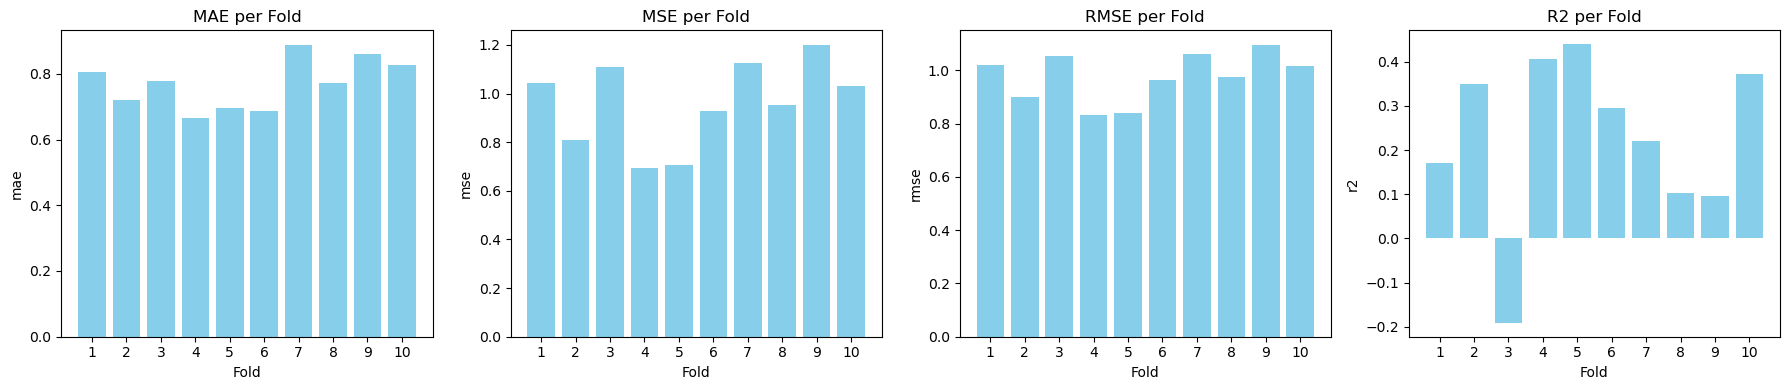

📊 Mean ± Std for Cross-Validation Metrics:


,mean,std
mae,0.7699,0.0762
mse,0.9599,0.1755
rmse,0.9759,0.0917
r2,0.2265,0.1912


In [30]:
# %%
import pandas as pd
import matplotlib.pyplot as plt

# Load summary
cv_path = os.path.join(results_dir, "crossval_summary.csv")
cv_df = pd.read_csv(cv_path)

# Choose metrics
task_metrics = (
    ['accuracy','precision','recall','f1_score','auc_roc']
    if task=="classification"
    else ['mae','mse','rmse','r2']
)

# Plot bar charts per fold
fig, axs = plt.subplots(1, len(task_metrics), figsize=(18, 4))
for i, metric in enumerate(task_metrics):
    axs[i].bar(cv_df['fold'], cv_df[metric], color='skyblue')
    axs[i].set_title(f"{metric.upper()} per Fold")
    axs[i].set_xlabel("Fold")
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(cv_df['fold'])

plt.tight_layout()
plt.show()

# Display mean ± std
summary_stats = cv_df[task_metrics].agg(['mean','std']).T
print("📊 Mean ± Std for Cross-Validation Metrics:")
display(summary_stats.round(4))


# ## Step 6a: Ensemble Averaging from Cross-Validation Models

In [33]:
# Load test data
ensemble_preds = []
test_data = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

# Ensure model configuration matches
output_dim = num_classes if task == "classification" else 1

# Collect predictions from each fold model
for fold in range(10):
    model = MPNN(input_dim, edge_dim, hidden_dim=best_hidden_dim, output_dim=output_dim, dropout=best_dropout).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval()
    fold_outputs = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            fold_outputs.append(out.cpu())
    ensemble_preds.append(torch.cat(fold_outputs, dim=0))

# Average predictions across folds
avg_output = torch.stack(ensemble_preds).mean(dim=0)

# Prepare final predictions and true labels
if task == "classification":
    final_pred = avg_output.argmax(dim=1).numpy()
    true_labels = torch.cat([data.y for data in test_data]).numpy().astype(int)
else:
    final_pred = avg_output.squeeze().numpy()
    true_value = torch.cat([data.y for data in test_data]).numpy()

print(f"✅ Ensemble predictions ready: shape {final_pred.shape}")

✅ Ensemble predictions ready: shape (53,)


# ## Step 6b: Ensemble Evaluation & Visualization


Ensemble: MAE=0.740, RMSE=0.915, R2=0.370


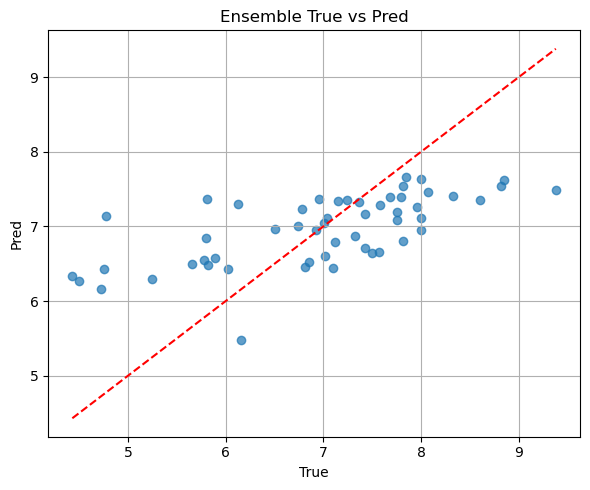

In [34]:


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
mae = mean_absolute_error(true_value, final_pred)
mse = mean_squared_error  (true_value, final_pred)
rmse= np.sqrt(mse)
r2  = r2_score           (true_value, final_pred)
print(f"Ensemble: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
plt.figure(figsize=(6,5)); plt.scatter(true_value,final_pred,alpha=0.7)
plt.plot([true_value.min(),true_value.max()],[true_value.min(),true_value.max()], 'r--'); plt.xlabel("True"); plt.ylabel("Pred"); plt.title("Ensemble True vs Pred"); plt.grid(True); plt.tight_layout(); plt.show()


# ## Step 7: Final Model Training on Combined Data & Test Evaluation


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 01 | Train 2.6383 | Val 0.8345
Epoch 02 | Train 1.0867 | Val 0.8507
Epoch 03 | Train 1.0685 | Val 1.1212
Epoch 04 | Train 1.0951 | Val 0.9653
Epoch 05 | Train 1.1139 | Val 1.0248
Epoch 06 | Train 1.1170 | Val 0.7761
Epoch 07 | Train 1.0806 | Val 1.0999
Epoch 08 | Train 1.0465 | Val 0.7472
Epoch 09 | Train 1.0652 | Val 0.7656
Epoch 10 | Train 1.2027 | Val 1.0557
Epoch 11 | Train 0.9890 | Val 0.7543
Epoch 12 | Train 1.0269 | Val 0.7997
Epoch 13 | Train 0.9624 | Val 1.1722
Epoch 14 | Train 1.0560 | Val 0.7600
Epoch 15 | Train 1.0514 | Val 0.7684
Epoch 16 | Train 0.9559 | Val 1.1936
Epoch 17 | Train 0.9564 | Val 0.7782
Epoch 18 | Train 0.9951 | Val 0.7294
Epoch 19 | Train 0.9799 | Val 0.7456
Epoch 20 | Train 1.0125 | Val 0.8608
Epoch 21 | Train 0.9507 | Val 0.7771
Epoch 22 | Train 0.9062 | Val 0.7507
Epoch 23 | Train 0.8997 | Val 0.8416
Epoch 24 | Train 0.9636 | Val 0.7332
Epoch 25 | Train 0.9397 | Val 0.7671
Epoch 26 | Train 0.9106 | Val 0.7301
Epoch 27 | Train 0.9144 | Val 0.7627
E

,metric,ensemble,final
0,MAE,0.785776,0.722072
1,RMSE,0.983218,0.936037
2,R2,0.272208,0.340379


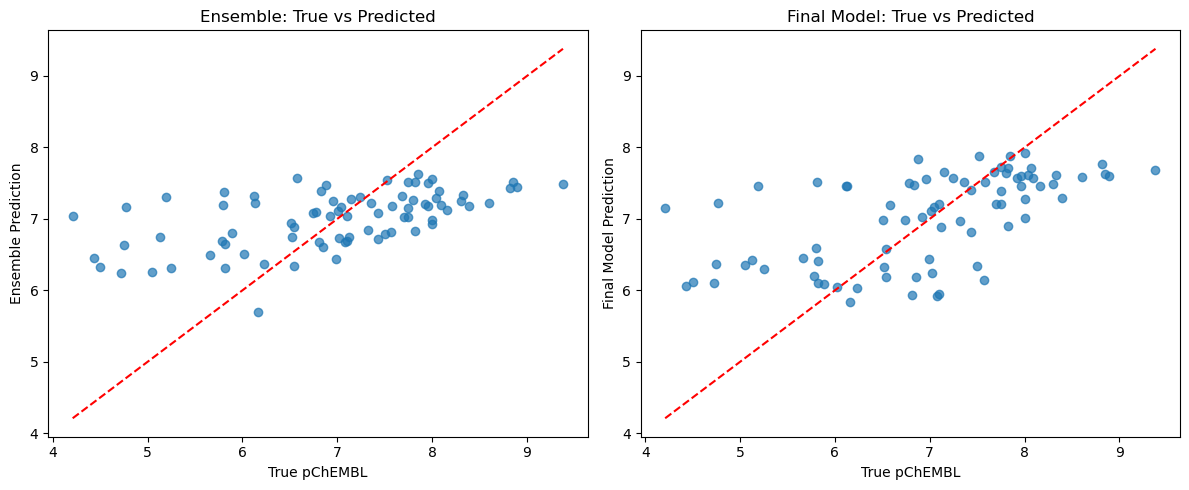

In [224]:
all_data=[]
for fold in range(5):
    all_data += torch.load(os.path.join(base_path,f"{task}_train_fold{fold}.pt"))
    all_data += torch.load(os.path.join(base_path,f"{task}_val_fold{fold}.pt"))
# Split off small validation for early stopping
tidx, vidx = train_test_split(range(len(all_data)), test_size=0.1, random_state=seed)
train_split=[all_data[i] for i in tidx]; val_split=[all_data[i] for i in vidx]
train_loader=DataLoader(train_split,batch_size=32,shuffle=True)
val_loader  =DataLoader(val_split,  batch_size=32)
model=MPNN(input_dim,edge_dim,hidden_dim=best_hidden_dim,output_dim=output_dim,dropout=best_dropout).to(device)
opt=torch.optim.Adam(model.parameters(),lr=best_lr)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=5,factor=0.5,verbose=True)
best_val = float('inf')
pt = 0
for epoch in range(1,100):
    model.train(); tot=0
    for b in train_loader: b=b.to(device); opt.zero_grad(); o=model(b); l=F.mse_loss(o.squeeze(),b.y); l.backward(); opt.step(); tot+=l.item()
    preds,trues=evaluate(model,val_loader); vloss=F.mse_loss(preds.squeeze(),trues).item()
    scheduler.step(vloss); print(f"Epoch {epoch:02d} | Train {tot/len(train_loader):.4f} | Val {vloss:.4f}")
    if vloss<best_val: best_val=vloss; pt=0; torch.save(model.state_dict(),os.path.join(results_dir,"final_model.pt"))
    else: pt+=1; 
    if pt>=10: 
        print("⏹️ Early stopping"); 
        break
# Load best and evaluate on test
model.load_state_dict(torch.load(os.path.join(results_dir,"final_model.pt")))
out,tru=evaluate(model,DataLoader(test_data,batch_size=32))
pred_final=out.squeeze().numpy(); true_final=tru.numpy()
mae_f=mean_absolute_error(true_final,pred_final); mse_f=mean_squared_error(true_final,pred_final)
rmse_f=np.sqrt(mse_f); r2_f=r2_score(true_final,pred_final)
print(f"Final: MAE={mae_f:.3f}, RMSE={rmse_f:.3f}, R2={r2_f:.3f}")
# Compare
comp = pd.DataFrame({ 'metric':['MAE','RMSE','R2'], 'ensemble':[mae, rmse, r2], 'final':[mae_f, rmse_f, r2_f] })
display(comp)

# Side-by-side scatter plots for Ensemble vs Final Model
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Ensemble plot
axes[0].scatter(true_value, final_pred, alpha=0.7)
axes[0].plot([true_value.min(), true_value.max()], [true_value.min(), true_value.max()], 'r--')
axes[0].set_title('Ensemble: True vs Predicted')
axes[0].set_xlabel('True pChEMBL')
axes[0].set_ylabel('Ensemble Prediction')

# Final model plot
axes[1].scatter(true_final, pred_final, alpha=0.7)
axes[1].plot([true_final.min(), true_final.max()], [true_final.min(), true_final.max()], 'r--')
axes[1].set_title('Final Model: True vs Predicted')
axes[1].set_xlabel('True pChEMBL')
axes[1].set_ylabel('Final Model Prediction')

plt.tight_layout()
plt.show()

In [35]:
# %% [markdown]
# ## Step 8: Final Model Training on Combined Train+Val & Test Evaluation (Hold‑Out Test)

# %%
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# 1) Merge all train+val folds
all_data = []
for fold in range(10):
    all_data += torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    all_data += torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

# 2) Reserve a small val split for early stopping
tidx, vidx = train_test_split(
    list(range(len(all_data))),
    test_size=0.10,
    random_state=seed,
    shuffle=True
)
train_split = [all_data[i] for i in tidx]
val_split   = [all_data[i] for i in vidx]

train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_split,   batch_size=32)

# 3) Instantiate & train final model
model     = MPNN(input_dim, edge_dim,
                 hidden_dim=best_hidden_dim,
                 output_dim=output_dim,
                 dropout=best_dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5, verbose=True
)

best_val_loss = float('inf')
patience      = 0

for epoch in range(1, 300):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = (F.cross_entropy(out, batch.y.long())
                if task == "classification"
                else F.mse_loss(out.squeeze(), batch.y))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation for early stopping
    preds, targets = evaluate(model, val_loader)
    val_loss = (F.cross_entropy(preds, targets.long()).item()
                if task == "classification"
                else F.mse_loss(preds.squeeze(), targets).item())

    scheduler.step(val_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience      = 0
        torch.save(model.state_dict(), os.path.join(results_dir, "final_model.pt"))
    else:
        patience += 1
        if patience >= 10:
            print("⏹️ Early stopping")
            break

# 4) Load best final model & evaluate on ORIGINAL TEST set
model.load_state_dict(torch.load(os.path.join(results_dir, "final_model.pt")))
test_data   = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

preds, targets = evaluate(model, test_loader)
pred_final     = (preds.argmax(dim=1).numpy() 
                  if task=="classification" 
                  else preds.squeeze().numpy())
true_final     = torch.cat([d.y for d in test_data]).numpy().astype(int if task=="classification" else float)

# 5) Compute final metrics
if task == "classification":
    from sklearn.metrics import (
        accuracy_score,
        precision_recall_fscore_support,
        roc_auc_score
    )
    acc       = accuracy_score(true_final, pred_final)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_final, pred_final, average="weighted", zero_division=0
    )
    probs     = F.softmax(preds, dim=1).cpu().numpy()
    auc       = roc_auc_score(
        label_binarize(true_final, classes=np.arange(num_classes)),
        probs, multi_class="ovr"
    )
    final_metrics = {
        "accuracy": acc, "precision": precision,
        "recall": recall, "f1_score": f1, "auc_roc": auc
    }
else:
    mae_f  = mean_absolute_error(true_final, pred_final)
    mse_f  = mean_squared_error(true_final, pred_final)
    rmse_f = np.sqrt(mse_f)
    r2_f   = r2_score(true_final, pred_final)
    final_metrics = {"mae": mae_f, "mse": mse_f, "rmse": rmse_f, "r2": r2_f}

# 6) Compare to Ensemble
comp = pd.DataFrame({
    "metric":    list(final_metrics.keys()),
    "ensemble":  list(comp.values()) if 'comp' in locals() else [mae, rmse, r2] if task!="classification" else [acc,precision,recall,f1,auc],  # adjust accordingly
    "final":     list(final_metrics.values())
})
display(comp)

# 7) Side-by-side scatter plots (regression example)
if task != "classification":
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Ensemble
    axes[0].scatter(true_labels, final_pred, alpha=0.7)
    axes[0].plot([true_labels.min(), true_labels.max()],
                 [true_labels.min(), true_labels.max()], 'r--')
    axes[0].set_title("Ensemble: True vs Predicted")
    axes[0].set_xlabel("True pChEMBL")
    axes[0].set_ylabel("Ensemble Prediction")
    # Final
    axes[1].scatter(true_final, pred_final, alpha=0.7)
    axes[1].plot([true_final.min(), true_final.max()],
                 [true_final.min(), true_final.max()], 'r--')
    axes[1].set_title("Final Model: True vs Predicted")
    axes[1].set_xlabel("True pChEMBL")
    axes[1].set_ylabel("Final Prediction")
    plt.tight_layout()
    plt.show()


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | Train Loss: 3.3237 | Val Loss: 0.9466
Epoch 002 | Train Loss: 0.9995 | Val Loss: 0.9226
Epoch 003 | Train Loss: 0.9738 | Val Loss: 0.9021
Epoch 004 | Train Loss: 0.9420 | Val Loss: 0.9192
Epoch 005 | Train Loss: 0.9335 | Val Loss: 0.8853
Epoch 006 | Train Loss: 0.9264 | Val Loss: 0.9203
Epoch 007 | Train Loss: 0.9150 | Val Loss: 1.0024
Epoch 008 | Train Loss: 0.9362 | Val Loss: 1.0411
Epoch 009 | Train Loss: 0.8821 | Val Loss: 0.9191
Epoch 010 | Train Loss: 0.8631 | Val Loss: 0.8930
Epoch 011 | Train Loss: 0.8806 | Val Loss: 0.8755
Epoch 012 | Train Loss: 0.8545 | Val Loss: 0.9670
Epoch 013 | Train Loss: 0.8447 | Val Loss: 0.8770
Epoch 014 | Train Loss: 0.8205 | Val Loss: 0.8717
Epoch 015 | Train Loss: 0.8374 | Val Loss: 0.8620
Epoch 016 | Train Loss: 0.7958 | Val Loss: 0.8777
Epoch 017 | Train Loss: 0.8441 | Val Loss: 0.9276
Epoch 018 | Train Loss: 0.8084 | Val Loss: 0.9082
Epoch 019 | Train Loss: 0.8204 | Val Loss: 1.0908
Epoch 020 | Train Loss: 0.7951 | Val Loss: 0.9142


ValueError: All arrays must be of the same length

,metric,ensemble,final
0,mae,0.740341,0.584790
1,mse,0.836766,0.615157
2,rmse,0.914749,0.784319
3,r2,0.370252,0.537035


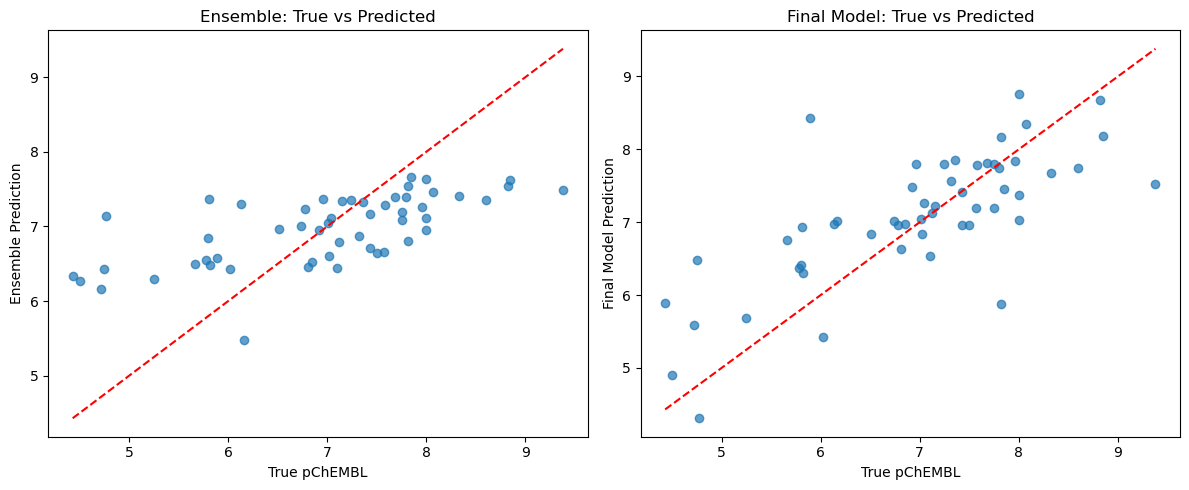

In [38]:
# 6) Compare to Ensemble
# Prepare ensemble metrics list
if task == "classification":
    ensemble_metrics = [acc, precision, recall, f1, auc]
else:
    ensemble_metrics = [mae, mse, rmse, r2]

# Create comparison DataFrame
comp = pd.DataFrame({
    "metric":   list(final_metrics.keys()),
    "ensemble": ensemble_metrics,
    "final":    list(final_metrics.values())
})
display(comp)

# 7) Side-by-side scatter plots
if task != "classification":
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Ensemble plot
    axes[0].scatter(true_value, final_pred, alpha=0.7)
    axes[0].plot(
        [true_value.min(), true_value.max()],
        [true_value.min(), true_value.max()],
        'r--'
    )
    axes[0].set_title("Ensemble: True vs Predicted")
    axes[0].set_xlabel("True pChEMBL")
    axes[0].set_ylabel("Ensemble Prediction")

    # Final model plot
    axes[1].scatter(true_final, pred_final, alpha=0.7)
    axes[1].plot(
        [true_final.min(), true_final.max()],
        [true_final.min(), true_final.max()],
        'r--'
    )
    axes[1].set_title("Final Model: True vs Predicted")
    axes[1].set_xlabel("True pChEMBL")
    axes[1].set_ylabel("Final Model Prediction")

    plt.tight_layout()
    plt.show()
